# Data

[Paler penguins dataset](https://allisonhorst.github.io/palmerpenguins/)

https://github.com/mcnakhaee/palmerpenguins

## Load and Prepare

In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp

from palmerpenguins import load_penguins

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def convert_label_to_ids(targets, id_dict):
    converted_targets = np.zeros(shape=(len(targets, )), dtype=np.int32)
    for idx, target in tqdm(enumerate(targets)):
        converted_targets[idx] = id_dict[target]

    return converted_targets



def prepare_penguins_data():
    penguins = load_penguins()
    
    # drop "nan" values
    penguins = penguins.dropna()
    
    feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    target_column = "species"

    features = penguins[feature_columns].values
    targets = penguins[target_column].values
    
    # since the targets are categorical
    # giving them int ids
    target_ids_dict = dict()
    unique_target_labels = set(targets)
    _id = 0
    for ul in unique_target_labels:
        target_ids_dict[ul] = _id
        _id += 1
        
    targets_converted = convert_label_to_ids(targets=targets, id_dict=target_ids_dict)
    assert features.shape[0] == targets_converted.shape[0]
    
    
    # normalize features
    features_norm = preprocessing.normalize(features, norm="l2")
    
        
    # create train test split
    features_train, features_test, targets_train, targets_test = train_test_split(
        features_norm, targets_converted, test_size=0.3, random_state=42)
    
    return features_train, features_test, targets_train, targets_test

In [3]:
features_train, features_test, targets_train, targets_test = prepare_penguins_data()

0it [00:00, ?it/s]

In [4]:
print(f"Train Size : {features_train.shape[0]}")
print(f"Test Size: {features_test.shape[0]}")

Train Size : 233
Test Size: 100


# Model

In [5]:
import flax.linen as nn

class PenguinFinder(nn.Module):
    in_features: int =  4 # 4 columns with features to classify penguins
    out_dim: int = 3 # number of classes
        
    @nn.compact
    def __call__(self, x):
        out = nn.Dense(features=self.in_features)(x)
        out = nn.Dense(features=self.out_dim)(out)
        out = nn.leaky_relu(out)
        
        # apply softmax
        logits = jax.nn.softmax(out)
        
        return logits

# Training Setup

## PyTorch style train loop

In [6]:
import optax
from tqdm.notebook import trange

def simple_train_loop(model, params, features, targets, ls_fn, lr=0.1, epochs=1000):
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)
    
    # gradient of loss function
    loss_grad_fn = jax.value_and_grad(ls_fn)
    
    # for visualization later
    losses = list()
    steps = list()
    step_count = 0
    
    # ============ train loop ==============
    for e in trange(epochs):
        loss, grads = loss_grad_fn(params, features, targets)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        if step_count % 50 == 0:
            losses.append(loss)
            steps.append(step_count)
        step_count += 1
        
    # =========================
    return params, losses, steps

## jit + flax state

In [7]:
from flax.training import train_state



def jit_train_loop(model, params, features, targets, ls_fn, lr=0.1, epochs=1000):
    # flax model state
    optimizer = optax.adam(learning_rate=0.1)
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx = optimizer)
    
    # gradient of loss function
    loss_grad_fn = jax.value_and_grad(ls_fn)
    assert loss_grad_fn is not None
    
    # a single train step
    @jax.jit
    def train_step(state, xs, ys):
        loss_value, grads = loss_grad_fn(state.params, xs, ys)
        state = state.apply_gradients(grads=grads)
        return loss_value, state
    
    
    # ==================== for vis
    losses = list()
    steps = list()
    step_count = 0
    
    # ==================== train loop
    for e in trange(epochs):
        loss, model_state = train_step(model_state, features, targets)
        if step_count % 50 == 0:
            losses.append(loss)
            steps.append(step_count)
        step_count += 1
        
    # ===============================
    return model_state, losses, steps
    


## Visualize Loss

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def vis(losses, steps):
    sns.lineplot(x=np.array(steps), y=np.array(losses))
    plt.show()

# Create two models and compare

## Init models

In [9]:
simple_model = PenguinFinder()
jit_model = PenguinFinder()

# PRNG keys
master_key = jax.random.PRNGKey(1971)
master_key, sub_key1, sub_key2 = jax.random.split(master_key, 3)

# params from both models
params_simple = simple_model.init(sub_key1, features_train[0])
params_jit = jit_model.init(sub_key2, features_train[0])

In [10]:
params_simple

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.5805933 , -0.3038017 , -0.1599638 ,  0.13707566],
                         [ 0.25928795, -0.53883463, -0.1308711 ,  0.02645478],
                         [-0.817803  ,  0.0530334 , -0.689189  ,  0.75184387],
                         [ 0.04453415, -0.10775283, -0.21034738,  0.45976543]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[-0.36507347,  0.40669972, -0.47204724],
                         [-1.0150541 ,  1.0595707 , -0.64373904],
                         [ 0.22301356,  1.0505154 ,  0.1534924 ],
                         [ 0.9204447 , -0.36053044,  0.19022419]], dtype=float32),
            bias: DeviceArray([0., 0., 0.], dtype=float32),
        },
    },
})

In [11]:
params_jit

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.9005664 ,  0.66599697,  0.5845482 ,  0.04085948],
                         [ 0.82358   , -0.31116712,  0.04395251,  0.97363275],
                         [-0.7349991 , -0.1704876 , -0.81940633, -0.919815  ],
                         [-0.33253327, -0.3536282 , -0.16050176,  0.87292576]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[-0.15390982, -0.20282869, -0.52689606],
                         [-0.5096369 ,  1.0160853 , -0.08643549],
                         [ 0.0984989 ,  0.63070726,  0.6486512 ],
                         [-0.45895505,  0.2593311 , -0.534587  ]], dtype=float32),
            bias: DeviceArray([0., 0., 0.], dtype=float32),
        },
    },
})

## Loss functions

In [12]:
# simple 
@jax.jit
def cross_entropy_simple(params, x, y):
    logits = simple_model.apply(params, x)
    return -jnp.log(logits[y])

@jax.jit
def calculate_loss_simple(params, xs, ys):
    return jnp.mean(
        jax.vmap(cross_entropy_simple, in_axes=(None, 0, 0))(params, xs, ys)
    )

In [13]:
# jit state

@jax.jit
def cross_entropy_jstate(params, x, y):
    logits = jit_model.apply(params, x)
    return -jnp.log(logits[y])

@jax.jit
def calculate_loss_jstate(params, xs, ys):
    return jnp.mean(
        jax.vmap(cross_entropy_jstate, in_axes=(None, 0, 0))(params, xs, ys)
    )

## Evaluate

In [14]:
# jit model
@jax.jit
def test_step(state, x):
    logits = jit_model.apply(state.params, x)
    out = jnp.argmax(logits, axis=-1)
    
    return out
    

@jax.jit
def test(state, xs):
    return jax.vmap(test_step, in_axes=(None, 0))(state, xs)

In [15]:
# simple model

@jax.jit
def test_step(params, x):
    logits = simple_model.apply(params, x)
    out = jnp.argmax(logits, axis=-1)
    
    return out

@jax.jit
def test(params, xs):
    return jax.vmap(test_step, in_axes=(None, 0))(params, xs)

In [16]:
from sklearn.metrics import classification_report

def report(pred, true):
    report = classification_report(y_pred=pred, y_true=true)
    print(report)

## Train

In [17]:
trained_params_simple, losses_simple, steps_simple = simple_train_loop(
    model=simple_model, 
    params=params_simple, 
    features=features_train, 
    targets=targets_train,
    ls_fn=calculate_loss_simple,
    lr=0.1, 
    epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
trained_params_jit, losses_jit, steps_jit = jit_train_loop(
    model=jit_model, 
    params=params_jit, 
    features=features_train, 
    targets=targets_train,
    ls_fn=calculate_loss_jstate,
    lr=0.1, 
    epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Visualization and Evaluation

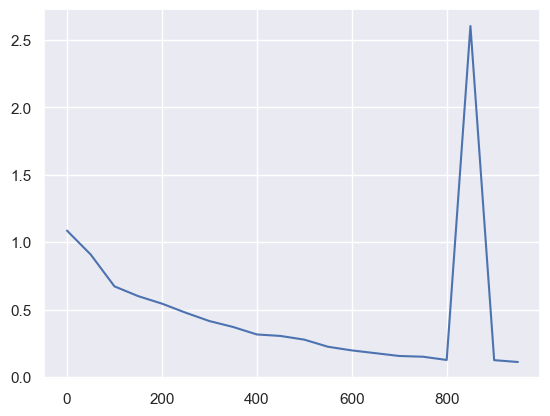

In [19]:
vis(losses_simple, steps_simple)

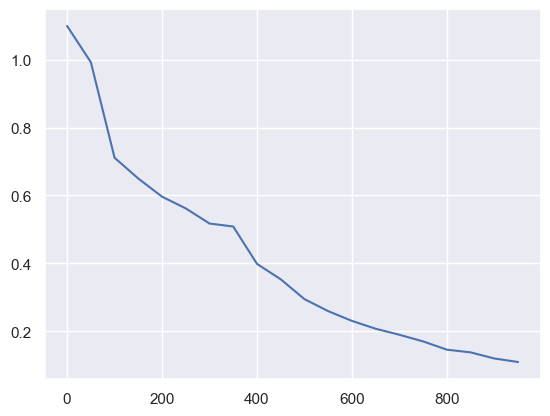

In [20]:
vis(losses_jit, steps_jit)

In [21]:
# simple
report(pred=test(trained_params_simple, features_test), true=targets_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.95      0.91      0.93        23
           2       0.96      0.96      0.96        48

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [22]:
# jit state
report(pred=test(trained_params_jit.params, features_test), true=targets_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.95      0.91      0.93        23
           2       0.96      0.96      0.96        48

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

